<a href="https://colab.research.google.com/github/Mogreine29/HandsOnAI_2/blob/main/Challenge2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!/opt/bin/nvidia-smi
!rm -rf sample_data

Thu Dec 15 12:51:14 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    31W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
#!pip3 -q install transformers
#!pip3 -q install datasets

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import gensim
import keras
from keras_preprocessing import text, sequence
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout
import re
import string
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/My\ Drive/Challenge2

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1aIAK0Qi-pofkSLi3xijkAex-JrSW_tn8/Challenge2


In [6]:
df_train = pd.read_csv('/content/drive/MyDrive/Challenge2/fake_train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Challenge2/fake_test.csv')

df_train.head()

,Unnamed: 0,data,label,target_name
0,0,Au 22e jour consécutif de la grève reconductib...,0,News
1,1,"Depuis plusieurs mois, les initiatives des che...",0,News
2,2,Google vient d'introduire une mise à jour de...,0,News
3,3,Portrait. Chacun s’empresse autour d’elle tan...,0,News
4,4,« Il n’y a pas de risque de pénurie » de carbu...,0,News


In [7]:
df_train.isna().sum()

Unnamed: 0     0
data           0
label          0
target_name    0
dtype: int64

In [8]:
df_test.isna().sum()

Unnamed: 0     0
data           0
label          0
target_name    0
dtype: int64

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


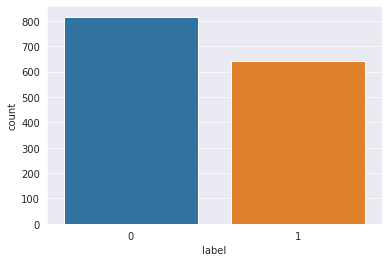

In [9]:
#Jeu de données en équilibre ou non

sns.set_style("darkgrid")
sns.countplot(df_train.label)

In [10]:
df_train = df_train.drop(['Unnamed: 0', 'target_name'], axis = 1)
df_test = df_test.drop(['Unnamed: 0', 'target_name'], axis = 1)

df_train.head()

,data,label
0,Au 22e jour consécutif de la grève reconductib...,0
1,"Depuis plusieurs mois, les initiatives des che...",0
2,Google vient d'introduire une mise à jour de...,0
3,Portrait. Chacun s’empresse autour d’elle tan...,0
4,« Il n’y a pas de risque de pénurie » de carbu...,0


In [11]:
STOPWORDS = set(stopwords.words('french'))

def cleaner(text):
    text = text.lower()
    #removing square brackets
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text) 
    #removing URL's
    text = re.sub('https?://\S+|www\.\S+', '', text)
    #removing <>
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)

    text = ' '.join(word for word in text.split() if word not in STOPWORDS)   
    return text

In [12]:
df_train['data'] = df_train['data'].apply(cleaner)
df_test['data'] = df_test['data'].apply(cleaner)

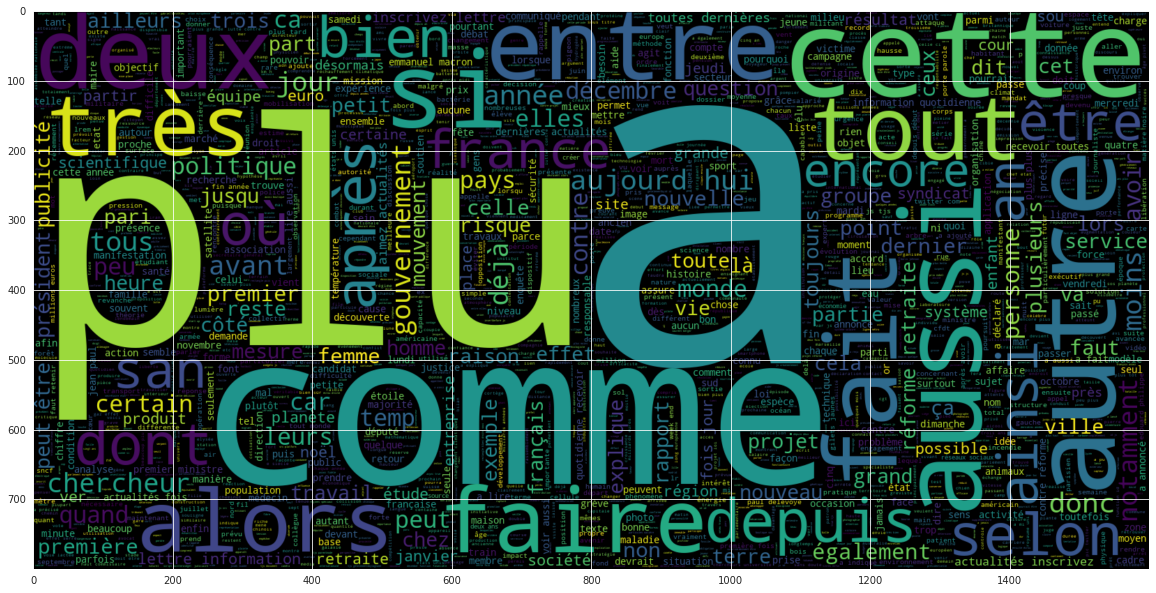

In [13]:
plt.figure(figsize = (20,20)) # Text that is not Fake
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df_train[df_train.label == 0].data))
plt.imshow(wc , interpolation = 'bilinear')

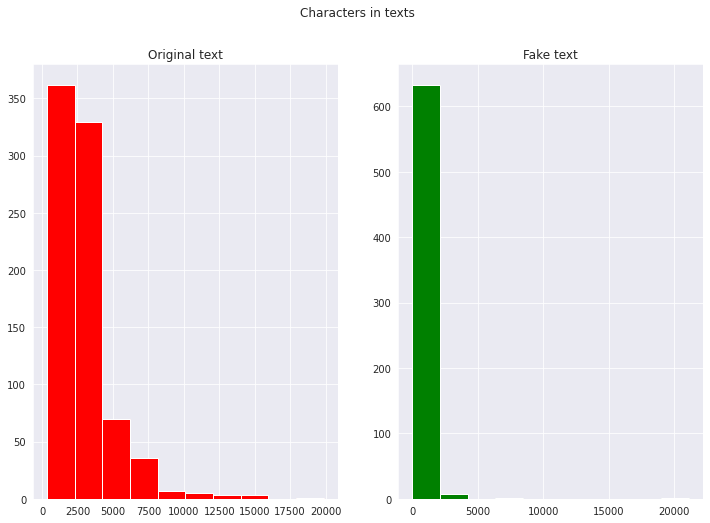

In [14]:
#Nombre de characters dans les textes

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=df_train[df_train['label']==0]['data'].str.len()
ax1.hist(text_len,color='red')
ax1.set_title('Original text')
text_len=df_train[df_train['label']==1]['data'].str.len()
ax2.hist(text_len,color='green')
ax2.set_title('Fake text')
fig.suptitle('Characters in texts')
plt.show()

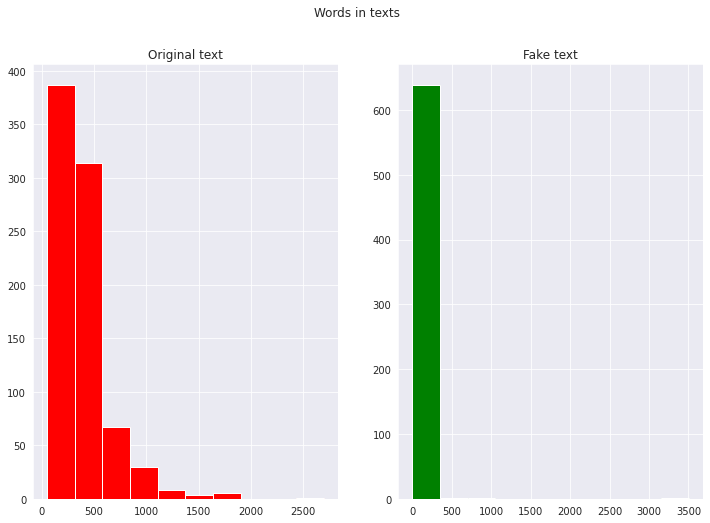

In [15]:
#Nombre de mots dans les textes

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=df_train[df_train['label']==0]['data'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='red')
ax1.set_title('Original text')
text_len=df_train[df_train['label']==1]['data'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='green')
ax2.set_title('Fake text')
fig.suptitle('Words in texts')
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.

Text(0.5, 0.98, 'Average word length in each text')

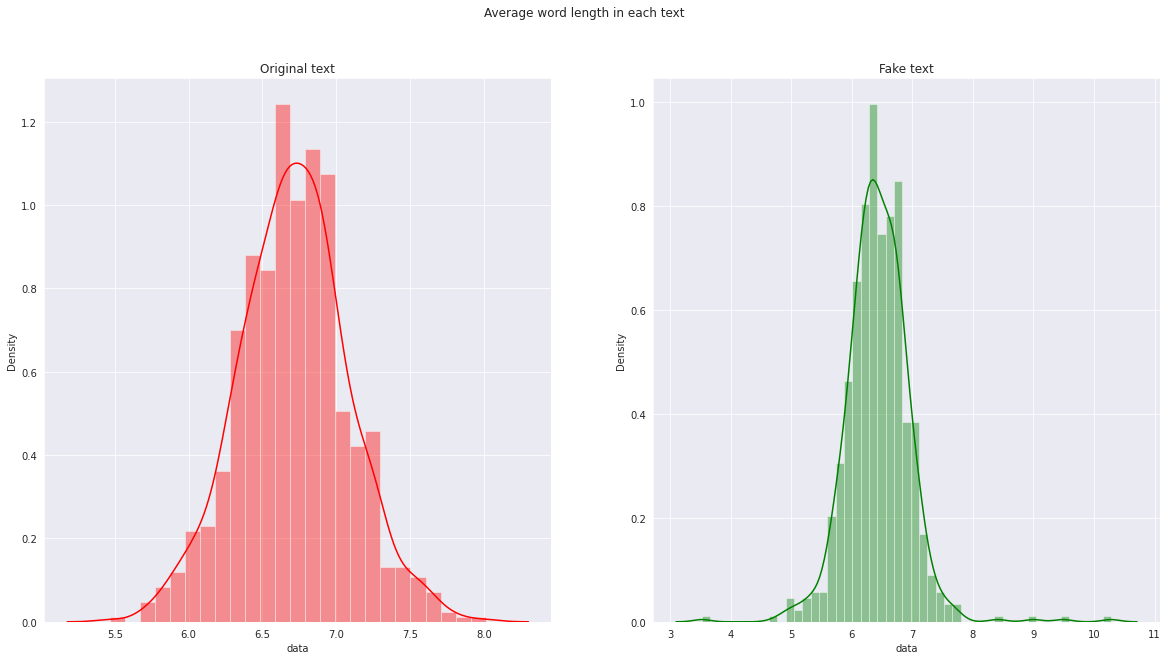

In [16]:
#Taille moyenne des mots dans les textes

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word=df_train[df_train['label']==0]['data'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('Original text')
word=df_train[df_train['label']==1]['data'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Fake text')
fig.suptitle('Average word length in each text')

In [17]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(df_train.data)
corpus[:5]

['jour', 'consécutif', 'grève', 'reconductible', 'contre']

In [18]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'a': 7733,
 'plus': 3814,
 'islam': 3471,
 'cette': 1839,
 'comme': 1653,
 'aussi': 1406,
 'être': 1369,
 'tout': 1323,
 'fait': 1281,
 'deux': 1128}

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

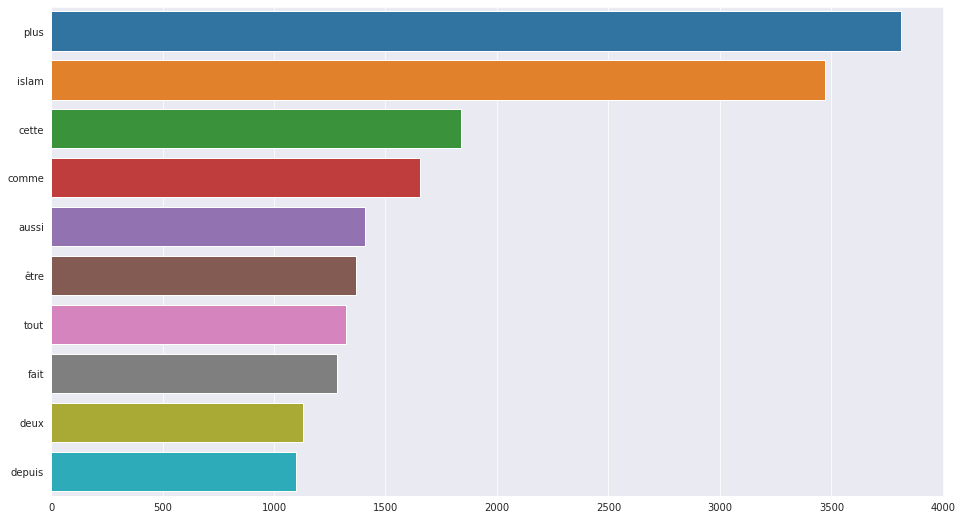

In [20]:
plt.figure(figsize = (16,9))
most_common_uni = get_top_text_ngrams(df_train.data,10,1)
most_common_uni = dict(most_common_uni)
sns.barplot(x=list(most_common_uni.values()),y=list(most_common_uni.keys()))

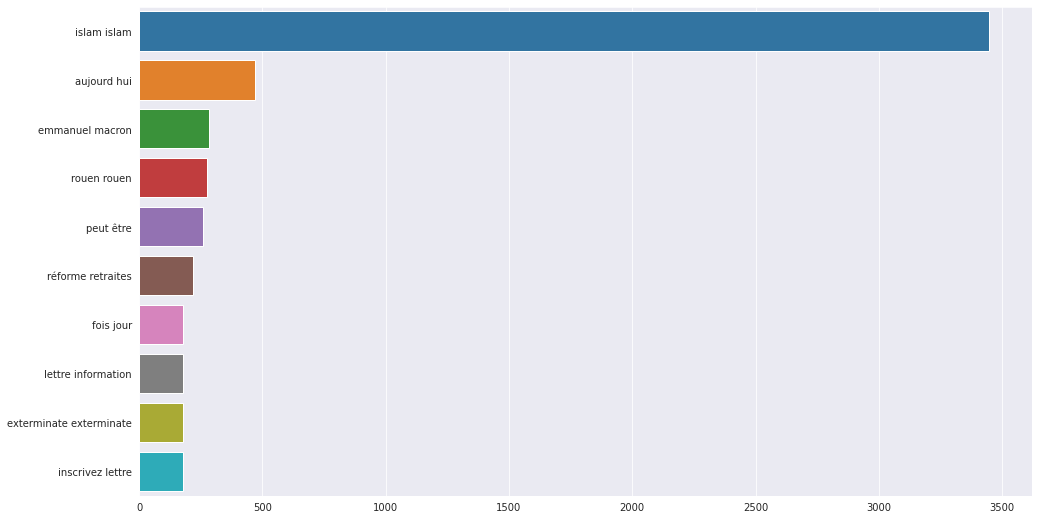

In [21]:
plt.figure(figsize = (16,9))
most_common_bi = get_top_text_ngrams(df_train.data,10,2)
most_common_bi = dict(most_common_bi)
sns.barplot(x=list(most_common_bi.values()),y=list(most_common_bi.keys()))

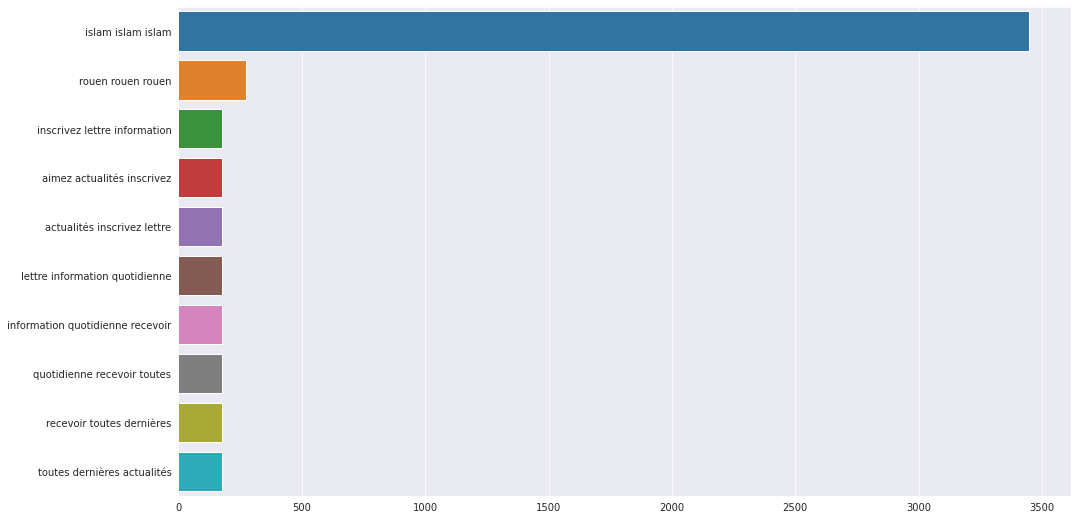

In [22]:
plt.figure(figsize = (16,9))
most_common_tri = get_top_text_ngrams(df_train.data,10,3)
most_common_tri = dict(most_common_tri)
sns.barplot(x=list(most_common_tri.values()),y=list(most_common_tri.keys()))

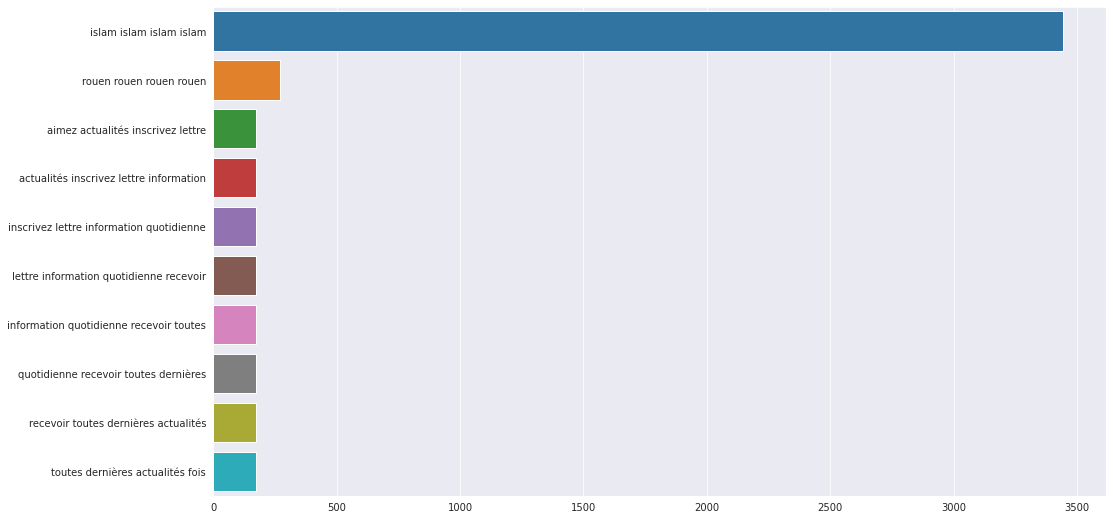

In [23]:
plt.figure(figsize = (16,9))
most_common_quad = get_top_text_ngrams(df_train.data,10,4)
most_common_quad = dict(most_common_quad)
sns.barplot(x=list(most_common_quad.values()),y=list(most_common_quad.keys()))

In [24]:
x_train = df_train["data"]
y_train = df_train["label"]

x_test = df_test["data"]
y_test = df_test["label"]

In [25]:
max_features = 10000
maxlen = 512

In [26]:
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)
tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)

In [27]:
tokenized_test = tokenizer.texts_to_sequences(x_test)
X_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen)

In [28]:
!wget https://embeddings.net/embeddings/frWac_non_lem_no_postag_no_phrase_200_cbow_cut100.bin

--2022-12-15 12:52:03--  https://embeddings.net/embeddings/frWac_non_lem_no_postag_no_phrase_200_cbow_cut100.bin
Resolving embeddings.net (embeddings.net)... 212.107.17.115, 2a02:4780:8:832:0:2384:2470:1
Connecting to embeddings.net (embeddings.net)|212.107.17.115|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 126052447 (120M) [application/octet-stream]
Saving to: ‘frWac_non_lem_no_postag_no_phrase_200_cbow_cut100.bin.3’

frWac_non_lem_no_po 100%[===================>] 120.21M  1.24MB/s    in 96s     

2022-12-15 12:53:40 (1.25 MB/s) - ‘frWac_non_lem_no_postag_no_phrase_200_cbow_cut100.bin.3’ saved [126052447/126052447]



In [29]:
word2vec_model_fr = gensim.models.KeyedVectors.load_word2vec_format("frWac_non_lem_no_postag_no_phrase_200_cbow_cut100.bin",binary=True)

In [ ]:
#Pour voir la forme des données

print("Loaded vocab size %i" % len(word2vec_model_fr.vocab.keys()))
print(word2vec_model_fr.vocab.keys())

In [31]:
embeddings_index = dict((key,word2vec_model_fr[key]) for key in word2vec_model_fr.vocab.keys())

In [ ]:
print(embeddings_index['il'])

In [33]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


In [34]:
batch_size = 256
epochs = 10
embed_size = 200

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

In [35]:
#Defining Neural Network
model = Sequential()

#Non-trainable embeddidng layer 
model.add(Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False))

#LSTM 
model.add(LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25))
model.add(LSTM(units=64 , recurrent_dropout = 0.1 , dropout = 0.1))
model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [36]:
model.build()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 512, 200)          2000000   
                                                                 
 lstm (LSTM)                 (None, 512, 128)          168448    
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,219,969
Trainable params: 219,969
Non-trainable params: 2,000,000
_________________________________________________________________


In [37]:
history = model.fit(x_train, y_train, batch_size = batch_size , validation_data = (X_test,y_test) , epochs = epochs , callbacks = [learning_rate_reduction])

Epoch 1/10
6/6 [==============================] - 34s 5s/step - loss: 0.7871 - accuracy: 0.6344 - val_loss: 0.6278 - val_accuracy: 0.6626 - lr: 0.0100
Epoch 2/10
6/6 [==============================] - 27s 4s/step - loss: 0.5161 - accuracy: 0.7401 - val_loss: 0.3021 - val_accuracy: 0.9074 - lr: 0.0100
Epoch 3/10
6/6 [==============================] - 27s 4s/step - loss: 0.3027 - accuracy: 0.9019 - val_loss: 0.2282 - val_accuracy: 0.9300 - lr: 0.0100
Epoch 4/10
6/6 [==============================] - 27s 4s/step - loss: 0.1825 - accuracy: 0.9472 - val_loss: 0.2594 - val_accuracy: 0.9115 - lr: 0.0100
Epoch 5/10
6/6 [==============================] - ETA: 0s - loss: 0.1481 - accuracy: 0.9561
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
6/6 [==============================] - 27s 4s/step - loss: 0.1481 - accuracy: 0.9561 - val_loss: 0.2115 - val_accuracy: 0.9239 - lr: 0.0100
Epoch 6/10
6/6 [==============================] - 26s 4s/step - loss: 0.1087 - accuracy: 

In [38]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train,y_train)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

46/46 [==============================] - 11s 245ms/step - loss: 0.0608 - accuracy: 0.9835
Accuracy of the model on Training Data is -  98.35391044616699 %
16/16 [==============================] - 4s 244ms/step - loss: 0.1790 - accuracy: 0.9465
Accuracy of the model on Testing Data is -  94.65020298957825 %


In [39]:
model.save('/content/drive/MyDrive/Challenge2/model2_0947.h5')

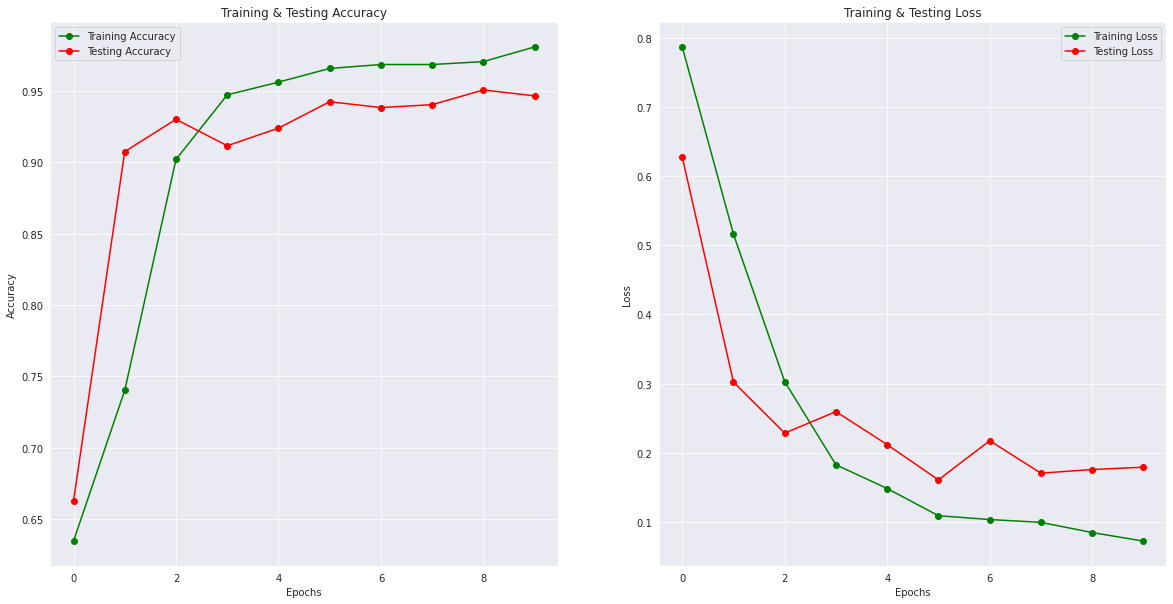

In [40]:
epochs = [i for i in range(10)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [41]:
pred = model.predict(X_test)
pred[:5]

16/16 [==============================] - 4s 239ms/step


array([[0.00838218],
       [0.00225958],
       [0.00418704],
       [0.00341573],
       [0.00337785]], dtype=float32)

In [42]:
print(classification_report(list(y_test), np.round(pred).astype(int), target_names = ['Not Fake','Fake']))

              precision    recall  f1-score   support

    Not Fake       0.98      0.93      0.95       272
        Fake       0.91      0.97      0.94       214

    accuracy                           0.95       486
   macro avg       0.94      0.95      0.95       486
weighted avg       0.95      0.95      0.95       486



In [43]:
cm = confusion_matrix(y_test,np.round(pred).astype(int))
cm

array([[252,  20],
       [  6, 208]])

In [44]:
cm = pd.DataFrame(cm , index = ['Fake','Original'] , columns = ['Fake','Original'])

Text(69.0, 0.5, 'Actual')

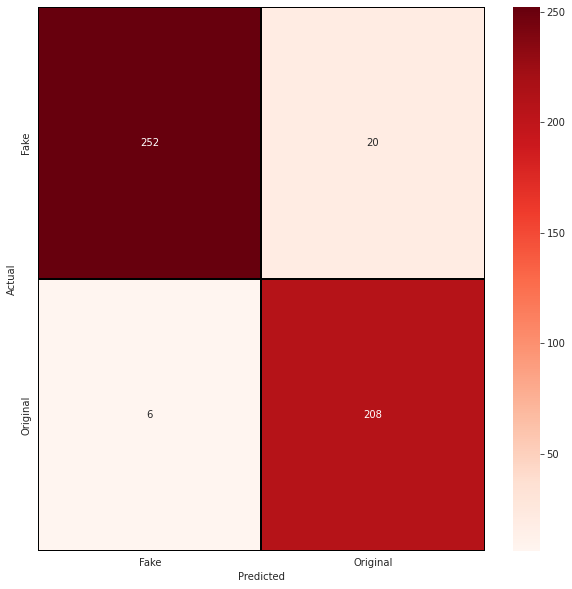

In [45]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Reds", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Fake','Original'] , yticklabels = ['Fake','Original'])
plt.xlabel("Predicted")
plt.ylabel("Actual")